# Inference of hierarchical Lognormal model parameters

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
sns.set_theme()

The data-generating distribution is
$$
    \log y \sim p(\cdot | \mu _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(\log y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, 1)
$$

Due to the conjugacy of Gaussian distributions, the hierarchical distribution
can be computed exactly to be

$$
    \log y \sim \mathcal{N}(\cdot | \mu _{\mathrm{pop}}, 2).
$$

Together with
a Gaussian prior $\mu _{\mathrm{pop}} \sim \mathcal{N}(\cdot | \mu _0 = 0, \sigma _0^2 = 16)$, we
can also use the conjugacy to compute the posterior
distribution analytically
$$
    p(\mu _{\mathrm{pop}} | \mathcal{D}) =
        \mathcal{N}(\mu _{\mathrm{pop}} | \mu ', \sigma '^2 ),
$$
where
$$
    \mu' = \sigma '^2\frac{n\overline{\log y}}{2},
    \quad
    \sigma '^2 = \frac{16}{1 + 8n}.
$$
Here, $n$ is the number of snapshot observations in the dataset
$\mathcal{D}=\{y_j^{\mathrm{obs}}\}$ and $\bar{y}$ denotes the empirical mean,
$\overline{\log y} = \sum _j \log y_j^{\mathrm{obs}} / n$.

# Synthesise data

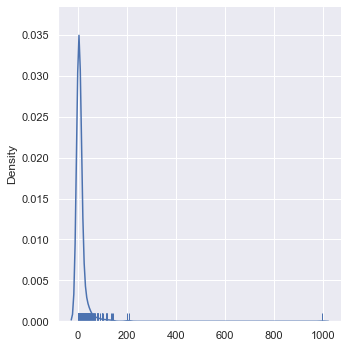

In [51]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean log, pop std. log, noise log
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    data[ids] = np.random.lognormal(
    mean=mean, sigma=true_parameters[2], size=n_samples_per_id)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact Gaussian log-likelihood
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood
4. Lognormal filter log-likelihood
5. Lognormal KDE filter log-likelihood
6. Rank matching Gaussian KDE filter likelihood
6. Data-centric Gaussian KDE filter log-likelihood

In [154]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = np.log(observations)
        self._n_ids, self._n_obs = observations.shape
        self._error_model = chi.GaussianErrorModel()
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        means = parameters[:self._n_ids]
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score = np.sum(
            scipy.stats.norm(loc=pop_mean, scale=pop_sigma).logpdf(
                means))
        if np.isinf(score):
            return score

        # Compute contributions from individual log-likelihoods
        for _id, mean in enumerate(means):
            score += np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations[_id]))

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        means = np.array(parameters[:self._n_ids])
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=means)

        # Compute individual contributions
        sensitivities = np.zeros(self.n_parameters())
        for _id, indiv_obs in enumerate(self._observations):
            s, sens = self._error_model.compute_sensitivities(
                parameters=[sigma],
                model_output=np.array([means[_id]] * self._n_obs),
                model_sensitivities=np.ones(shape=(self._n_obs, 1)),
                observations=indiv_obs)

            score += s
            sensitivities[_id] += sens[0]

        # Add population sensitivities
        sensitivities += pop_sens[:-1]

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 1

    def get_parameter_names(self):
        return ['Log mean'] * self._n_ids + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None]


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(mean_samples + sigma * epsilon)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute log-likelihood
        score = np.sum(
            scipy.stats.norm(loc=pop_mu_hat, scale=pop_sigma_hat).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(mean_samples + sigma * epsilon)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma * measurements / self._n_samples
        dpop_mu_hat_depsilon = sigma * measurements / self._n_samples
        dpop_mu_hat_dpop_mu = pop_mu_hat
        dpop_sigma_hat_deta = \
            pop_sigma * measurements * \
            (measurements - pop_mu_hat) / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * measurements * (measurements - pop_mu_hat) / \
            (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = pop_sigma_hat

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu]), shape=(n_obs, 2*self._n_samples + 1))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples:2*self._n_samples] \
            + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2*self._n_samples] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Log mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(mean_samples + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(mean_samples + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/deta = exp(score) / sum(exp(scores)) * dscore / deta
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * measurements[np.newaxis, :],
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * measurements[np.newaxis, :],
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * measurements[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Log mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class LognormalFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._lognormal = chi.LogNormalErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = mean_samples + sigma * epsilon
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(log_measurements, ddof=1)

        # Compute log-likelihood
        n_obs = len(self._observations)
        score = self._lognormal.compute_log_likelihood(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            observations=self._observations)

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = mean_samples + sigma * epsilon
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(log_measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma * measurements / self._n_samples
        dpop_mu_hat_depsilon = sigma * measurements / self._n_samples
        dpop_mu_hat_dpop_mu = pop_mu_hat
        dpop_sigma_hat_deta = \
            pop_sigma / pop_sigma_hat * \
            (log_measurements - np.mean(log_measurements)) \
            / (self._n_samples - 1)
        dpop_sigma_hat_depsilon = \
            sigma * (log_measurements - np.mean(log_measurements)) / \
            (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = 0

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu]), shape=(n_obs, 2*self._n_samples + 1))
        score, sens = self._lognormal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples:2*self._n_samples] \
            + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2*self._n_samples] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Log mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class LognormalKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._log_observations = np.log(observations.flatten())
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = self._n_samples ** (-0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/deta = exp(score) / sum(exp(scores)) * dscore / deta
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Log mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class RankMatchingGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        # NOTE: Gaussian error model is not the correct error model in this
        # case.
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var * measurements[:, np.newaxis] *
                (measurements[:, np.newaxis] - self._observations), axis=1)
        sensitivities[self._n_samples] = \
            -  np.sum(1 / kernel_var * measurements[:, np.newaxis] *
                (measurements[:, np.newaxis] - self._observations))

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None]


class DataCentricGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_obs = len(self._observations)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_obs) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu, epsilon = parameters
        sigma = 1
        measurement = np.exp(mu + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        score = self._n_obs * scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurement - self._observations)**2 \
            / self._kernel_scale**2 / 2) - np.log(self._n_obs)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu, epsilon = parameters
        sigma = 1
        measurement = np.exp(mu + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) \
            - (measurement - self._observations)**2 \
            / self._kernel_scale**2 / 2
        score = self._n_obs * (
            scipy.special.logsumexp(scores) - np.log(self._n_obs))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmu = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        softmax = \
            np.exp(scores - np.max(scores)) \
            / np.sum(np.exp(scores - np.max(scores)))

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[0] = \
            - self._n_obs / self._kernel_scale**2 \
            * np.sum(
                (measurement - self._observations) * softmax * measurement)
        sensitivities[1] = \
            - self._n_obs * sigma / self._kernel_scale**2 \
            * np.sum(
                (measurement - self._observations) * softmax * measurement)

        return score, sensitivities

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Log mean', 'Epsilon']

    def get_id(self):
        return [None] * 2

## Inference

### 1. Exact likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     66     0.157    32       0:03.5
1     67     0.25     1        0:03.6
2     68     0.25     1        0:03.6
3     131    0.499831 32       0:07.0
20    2495   0.751    132      2:12.6
40    4853   0.746    113      4:19.7
60    6714   0.765167 89       5:58.1
80    8452   0.756    83       7:30.1
100   10061  0.766    77       8:55.4
120   10545  0.708    24       9:20.7
140   10957  0.756    20       9:42.3
160   11311  0.705    17      10:00.8
180   11747  0.758    21      10:23.4
200   12119  0.743    18      10:42.6
220   12483  0.769    18      11:01.4
240   12847  0.757    18      11:20.5
260   13226  0.721    18      11:40.2
280   13606  0.764056 19      11:59.9
300   13954  0.754    17      12:17.9
320   14278  0.772    16      12:34.7
340   14650  0.735    18      12:54.1
360   14950  0.771    15      13:09.9
380   15250  0.753    15      13:26.4
400   15550  0.763

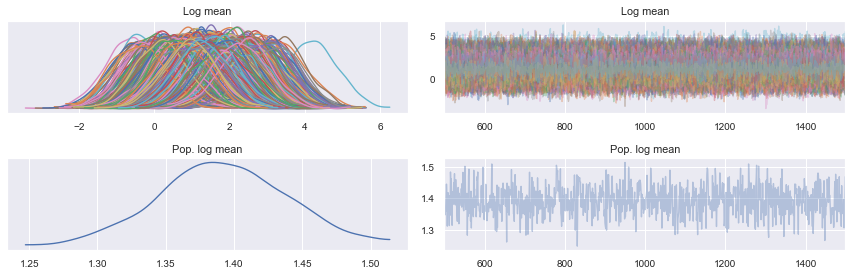

In [8]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = means
controller._initial_params[0, 0, -1] = 1
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [9]:
exact_posterior_samples.to_netcdf(
    'derived_data/posteriors/hierarchical_lognormal_model_exact.nc')

### 2. Gaussian filter likelihood

10 samples

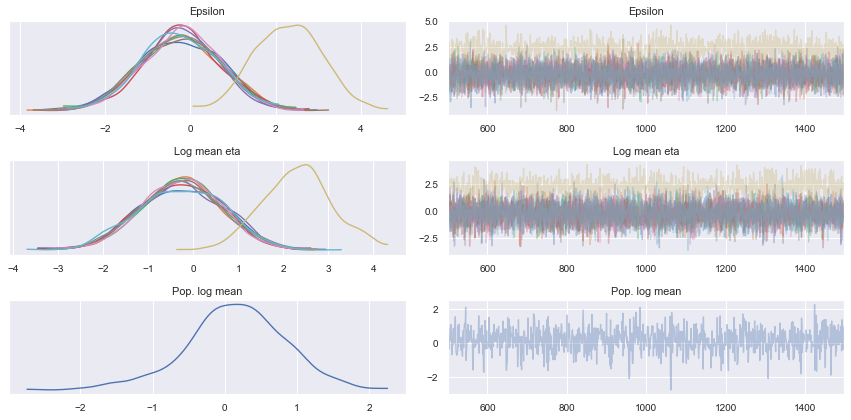

In [56]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/chi/_error_models.py:671: RuntimeWarning: divide by zero encountered in true_divide
  summed_squared_error / sigma**3 - n_obs / sigma
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in multiply
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in multiply
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


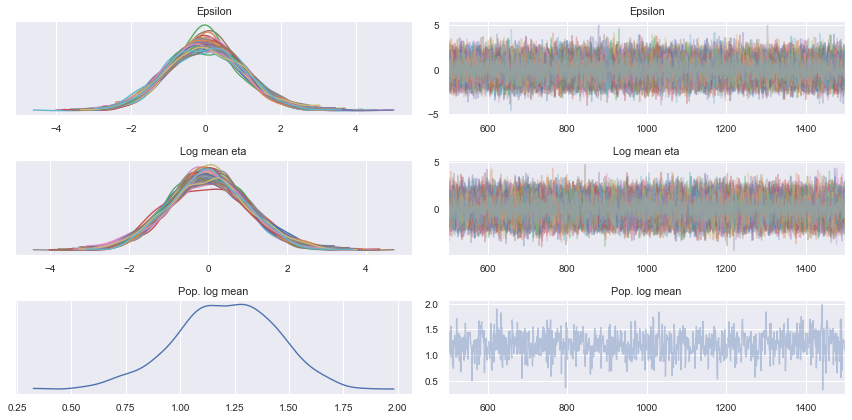

In [57]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in exp
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in subtract
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in subtract
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_l

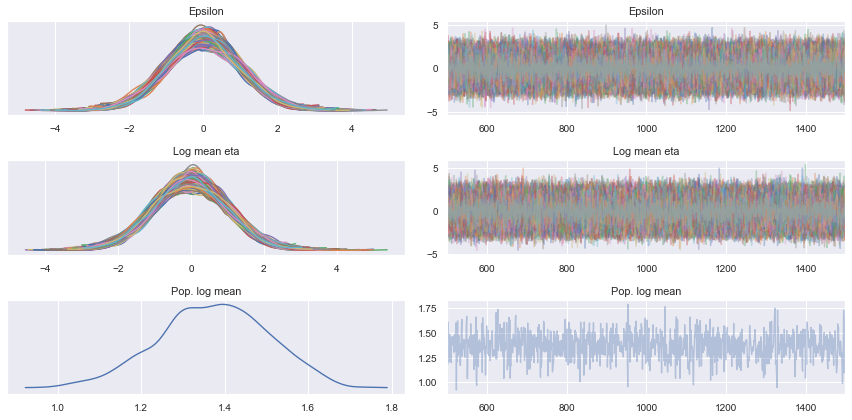

In [60]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [61]:
gaussian_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_lognormal_model_gaussian_filter_1000.nc')

### 3. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     10     0.162    2        0:00.1
1     11     0.25     1        0:00.1
2     13     0.168    1        0:00.1
3     28     0.465    8        0:00.1
20    182    0.736    9        0:00.2
40    2138   0.717    94       0:02.1
60    8271   0.749    293      0:08.3
80    12091  0.751    182      0:12.0
100   16729  0.733    221      0:16.4
120   24497  0.732    370      0:24.1
140   31302  0.74     325      0:30.8
160   34901  0.709    172      0:34.0
180   39779  0.778    233      0:38.2
200   44301  0.755    216      0:42.2
220   48118  0.77     182      0:45.4
240   51370  0.744    155      0:48.2
260   56703  0.71     254      0:52.8
280   63839  0.772    340      0:58.9
300   69507  0.742    270      1:03.7
320   75553  0.751    288      1:08.8
340   80661  0.778    244      1:13.0
360   85414  0.763    227      1:17.0
380   90194  0.759    228      1:20.9
400   94693  0.736

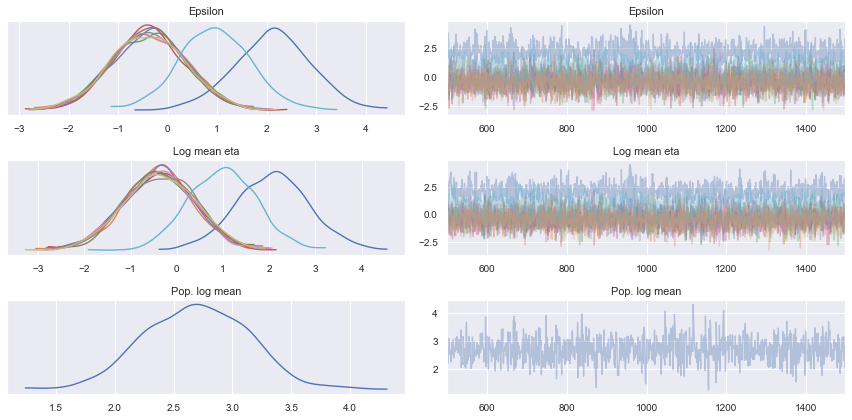

In [139]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     10     0.125    2        0:00.1
1     11     0.25     1        0:00.1
2     14     0.179    2        0:00.1
3     29     0.444    8        0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))


20    380    0.681    20       0:01.8
40    10699  0.754    492      0:45.7
60    18670  0.722984 380      1:18.7
80    27864  0.761    438      1:54.4
100   34981  0.721    339      2:22.2
120   40098  0.755    244      2:42.0
140   47018  0.747    330      3:05.7
160   53163  0.713    293      3:26.6
180   59379  0.782    296      3:48.4
200   63608  0.746    202      4:04.0
220   67448  0.769    183      4:19.2
240   72432  0.75     238      4:38.7
260   76818  0.704    209      4:55.9
280   83375  0.750924 313      5:21.3
300   87720  0.758    207      5:38.2
320   92730  0.76     239      5:57.8
340   97589  0.76     232      6:16.9
360   101801  0.756623 201      6:34.4
380   106548  0.745321 227      6:53.1
400   111435  0.76     233      7:11.5
420   115796  0.759    208      7:29.1
440   120526  0.763    226      7:48.0
460   124231  0.711819 177      8:02.9
480   131289  0.729    337      8:28.3
500   136929  0.767    269      8:47.5
520   142029  0.900915 243      9:07.7
540

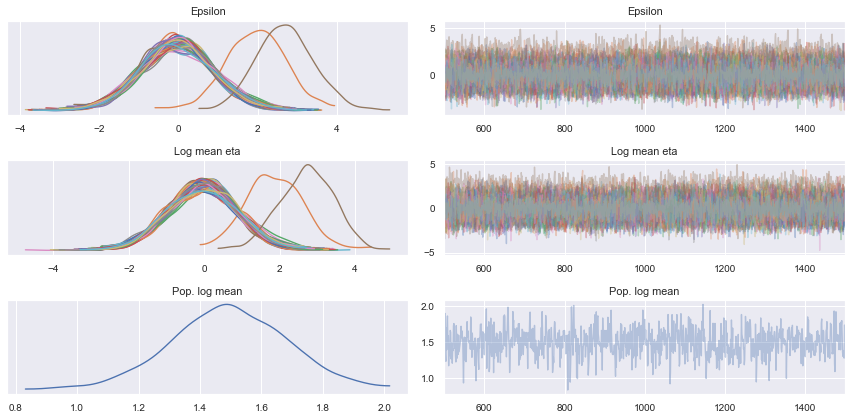

In [140]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [141]:
gaussian_kde_filter_100_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_lognormal_model_gaussian_kde_filter_100.nc')

1000 samples

In [146]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     19     0.161    8        0:01.0
1     22     0.125    2        0:01.1
2     34     0.241    6        0:01.7
3     68     0.384    17       0:03.5


KeyboardInterrupt: 

In [ ]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_lognormal_model_gaussian_kde_filter_1000.nc')

### 4. Lognormal filter likelihood

10 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


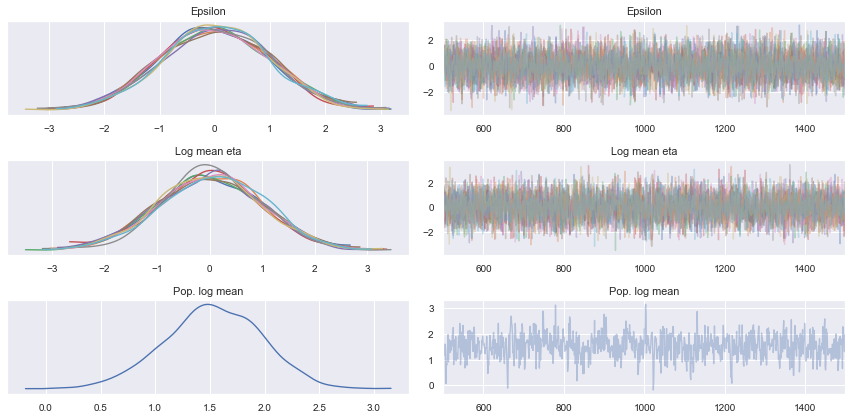

In [88]:
n_samples = 10
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    lognormal_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:313: RuntimeWarning: overflow encountered in exp
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/chi/_error_models.py:1019: RuntimeWarning: invalid value encountered in true_divide
  np.sum(error / model_output * model_sensitivities, axis=0) \
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:365: RuntimeWarning: invalid value encountered in double_scalars


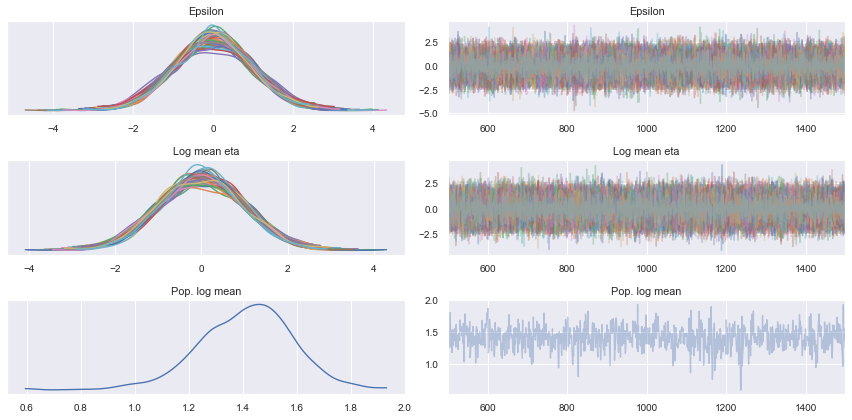

In [89]:
n_samples = 100
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    lognormal_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

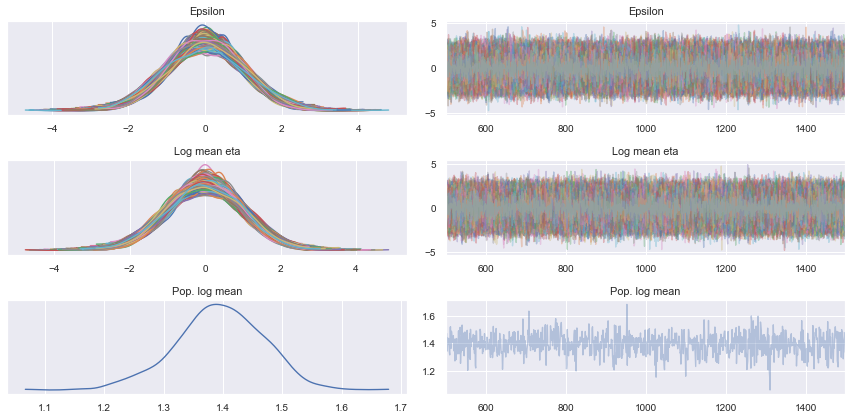

In [91]:
n_samples = 1000
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    lognormal_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 5. Lognormal KDE filter likelilhood

10 samples

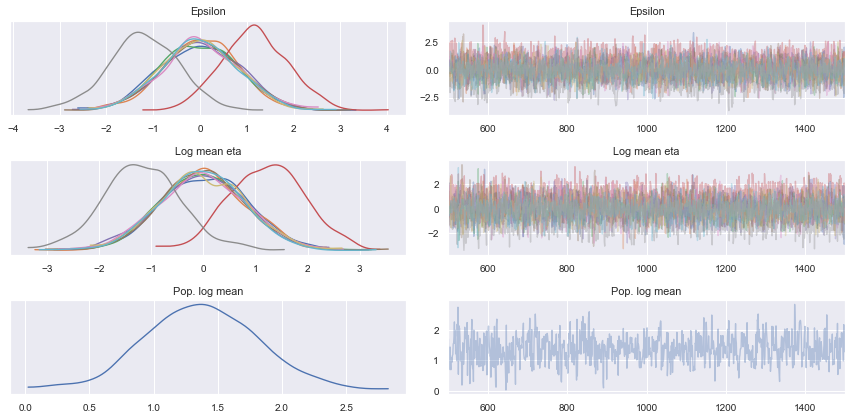

In [100]:
n_samples = 10
log_likelihood = LognormalKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    lognormal_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

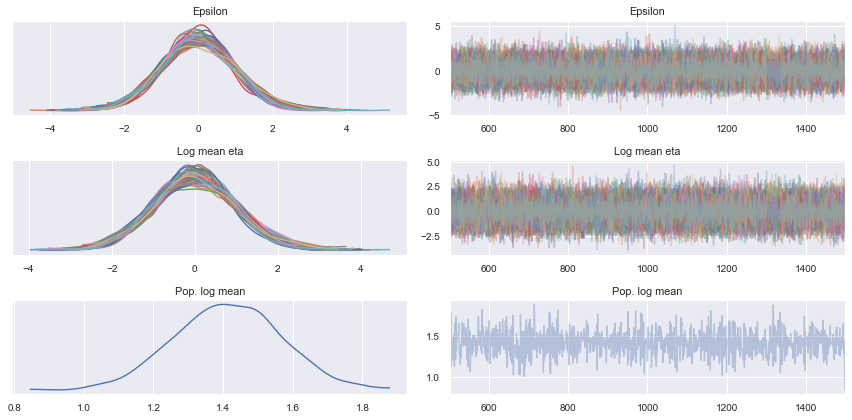

In [101]:
n_samples = 100
log_likelihood = LognormalKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    lognormal_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 6. Rank matching Gaussian KDE likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     136    0.5      64       0:00.1
1     137    0.25     1        0:00.1
2     138    0.25     1        0:00.1
3     139    0.5      1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    1046   0.79     51       0:00.3
40    2574   0.777962 73       0:00.7
60    4038   0.768    70       0:01.0
80    6460   0.754    116      0:01.4
100   9056   0.765009 124      0:01.9
120   11690  0.728    126      0:02.4
140   13332  0.756    79       0:02.7
160   14514  0.722    56       0:03.0
180   16887  0.772304 113      0:03.4
200   19471  0.763    124      0:03.9
220   20939  0.741    70       0:04.2
240   22711  0.757    85       0:04.5
260   24689  0.704    94       0:04.9
280   27121  0.786    116      0:05.4
300   29799  0.740719 128      0:06.0
320   31635  0.76     88       0:06.4
340   33431  0.743    86       0:06.7
360   34621  0.769459 57       0:07.0
380   36667  0.762    98       0:07.4
400   38049  0.746    66       0:07.8
420   39009  0.756    46       0:08.0
440   40997  0.76     95       0:08.4
460   43131  0.726    102      0:08.9
480   45871  0.744    131      0:09.5
500   48039  0.783    104      0:10.0
520   50111  0.841    99       0:10.4
540   52163 

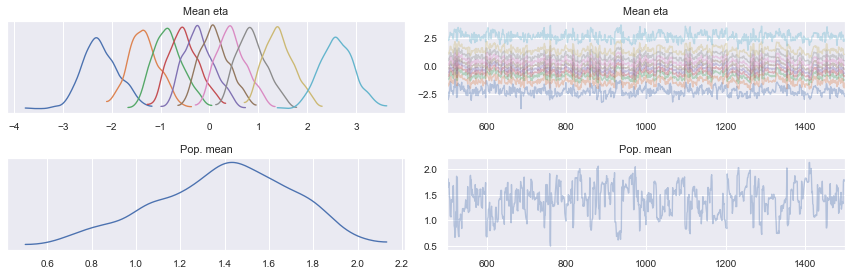

In [155]:
n_samples = 10
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     12     0.238    4        0:00.0
1     14     0.167    1        0:00.0
2     45     0.324    16       0:00.0
3     48     0.5      2        0:00.1
20    823    0.741    44       0:00.5
40    10796  0.757    475      0:06.7
60    19228  0.759616 402      0:11.4
80    27411  0.782    390      0:15.9
100   33552  0.749    293      0:19.9
120   35919  0.733    113      0:21.2
140   38127  0.734    106      0:22.6
160   40042  0.75258  91       0:23.6
180   42052  0.748    96       0:24.6
200   43728  0.75     80       0:25.7
220   45265  0.756    74       0:26.6
240   46818  0.762    74       0:27.4
260   48028  0.702    58       0:28.1
280   49030  0.73     48       0:28.7
300   50315  0.791    62       0:29.4
320   51274  0.754    46       0:30.0
340   52357  0.744    52       0:30.6
360   53284  0.756    45       0:31.2
380   54176  0.74     43       0:31.7
400   55025  0.784

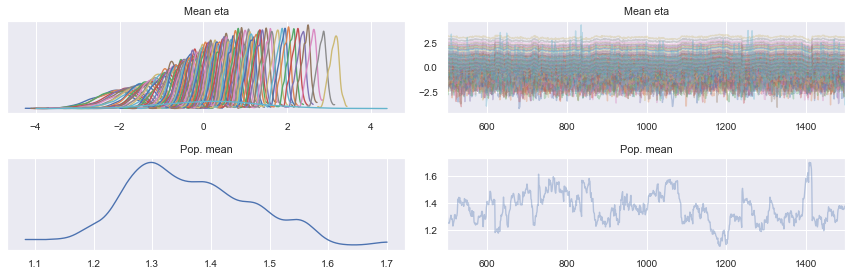

In [156]:
n_samples = 100
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     22     0.181    8        0:00.1
1     25     0.125    2        0:00.1
2     40     0.189    8        0:00.2
3     103    0.461    32       0:00.5
20    1334   0.737    69       0:05.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))


40    3439   0.802    101      0:14.1
60    13177  0.751    464      0:52.2
80    23220  0.752    479      1:33.5
100   33393  0.772051 484      2:16.2
120   49889  0.723    786      3:17.1
140   67311  0.77     830      4:23.1
160   75204  0.707    376      4:52.5
180   77839  0.76     126      5:03.8
200   80507  0.738    128      5:15.3
220   82999  0.773    119      5:24.6
240   85229  0.76     107      5:32.8
260   87546  0.703778 111      5:41.1
280   90101  0.754    122      5:50.9
300   92332  0.781    107      5:59.0
320   94186  0.746    89       6:05.8
340   96303  0.751    101      6:13.6
360   98083  0.748    85       6:20.0
380   99855  0.781    85       6:27.0
400   101830  0.725    95       6:34.2
420   103479  0.773    79       6:40.3
440   105080  0.749    77       6:46.1
460   107643  0.744    122      6:55.9
480   110913  0.73     156      7:07.8
500   113400  0.779    119      7:16.9
520   115940  0.863    121      7:26.1
540   118480  0.887    121      7:35.9
560 

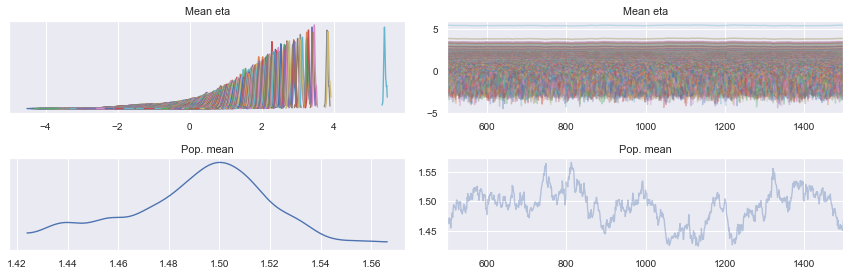

In [157]:
n_samples = 1000
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 7. Data-centric KDE likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.375    2        0:00.0
1     10     0.125    2        0:00.0
2     11     0.25     1        0:00.0
3     12     0.473    1        0:00.0
20    421    0.751    23       0:00.2
40    835    0.759    20       0:00.3
60    1143   0.758    15       0:00.3
80    1503   0.757    18       0:00.4
100   1695   0.73     9        0:00.5
120   2039   0.701    17       0:00.6
140   2385   0.771    17       0:00.7
160   2658   0.752    13       0:00.7
180   2982   0.752    16       0:00.8
200   3548   0.756    27       0:01.0
220   4064   0.765    25       0:01.1
240   4382   0.752    16       0:01.2
260   4866   0.717583 23       0:01.4
280   5208   0.759    17       0:01.5
300   5516   0.756    15       0:01.6
320   5894   0.732    18       0:01.7
340   6434   0.789968 26       0:01.8
360   6762   0.745    16       0:01.9
380   7134   0.766    18       0:02.0
400   7435   0.752

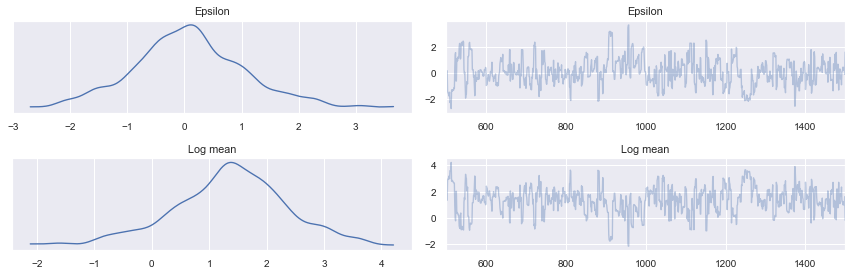

In [149]:
log_likelihood = DataCentricGaussianKDEFilterLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10),
    pints.GaussianLogPrior(0, 1)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
data_centric_gaussian_kde_filter_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

## Comparison to analytic posterior

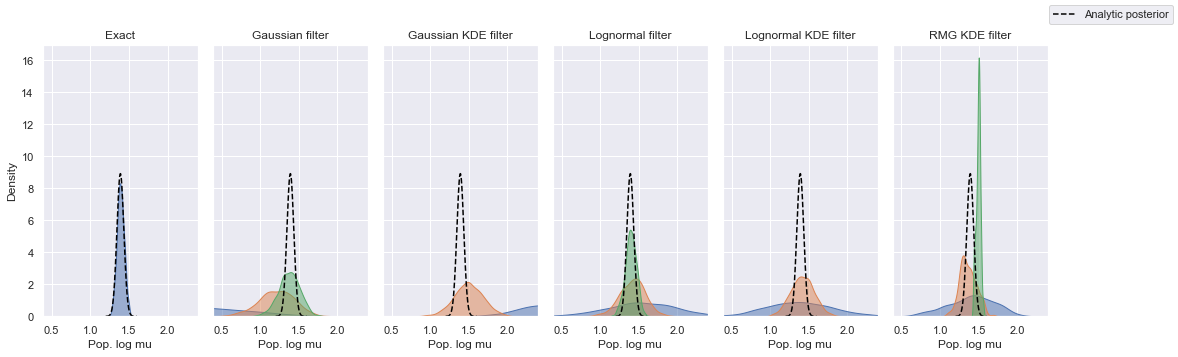

In [158]:
# Get true distribution
n = len(data)
posterior_var = 16 / (1 + n * 8)
posterior_mean = posterior_var * n * np.mean(np.log(data)) / 2
mus = np.linspace(1.2, 1.6, num=200)
true_pdf = scipy.stats.norm(posterior_mean, np.sqrt(posterior_var)).pdf(mus)

# Create figure
fig, axes = plt.subplots(
    1, 6, figsize=(18, 5), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0].set_xlim([posterior_mean - 1, posterior_mean + 1])
axes[0].set_xlabel('Pop. log mu')
axes[1].set_xlabel('Pop. log mu')
axes[2].set_xlabel('Pop. log mu')
axes[3].set_xlabel('Pop. log mu')
axes[4].set_xlabel('Pop. log mu')
axes[5].set_xlabel('Pop. log mu')
axes[0].set_title('Exact')
axes[1].set_title('Gaussian filter')
axes[2].set_title('Gaussian KDE filter')
axes[3].set_title('Lognormal filter')
axes[4].set_title('Lognormal KDE filter')
axes[5].set_title('RMG KDE filter')
colors = sns.color_palette()

# Plot exact likelihood inference
warmup = 500
thinning = 1
mu_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
    palette=colors[0], legend=False)

# Plot Gaussian filter posteriors
warmup = 1000
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[2], legend=False)

# Plot Gaussian KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

# Plot lognormal filter posteriors
warmup = 500
thinning = 1
mu_samples = lognormal_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = lognormal_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = lognormal_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

# Plot lognormal KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = lognormal_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[4],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = lognormal_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[4],
    palette=colors[0], legend=False)

# Plot RMG KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[1], legend=False)

# Overlay exact posterior
axes[0].plot(
    mus, true_pdf, color='black', linestyle='--', label='Analytic posterior')
axes[1].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[3].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[4].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[5].plot(
    mus, true_pdf, color='black', linestyle='--')

fig.legend()
plt.show()

## Comparison to true population distribution

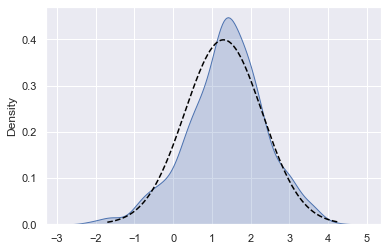

In [151]:
# Get true population distribution
n = len(data)
pop_mu, pop_sigma = true_parameters[:2]
mus = np.linspace(pop_mu - 3 * pop_sigma, pop_mu + 3 * pop_sigma, num=200)
true_pdf = scipy.stats.norm(pop_mu, pop_sigma).pdf(mus)

# Visualise results
ax = plt.plot(
    mus, true_pdf, color='black', linestyle='--',
    label='True population distribution')
samples = data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations))['Log mean'].values[0]
sns.kdeplot(x=samples, fill=True)

plt.show()

## Visualise posterior predictive Gaussian distribution (target distribution)

### Infer Gaussian distribution

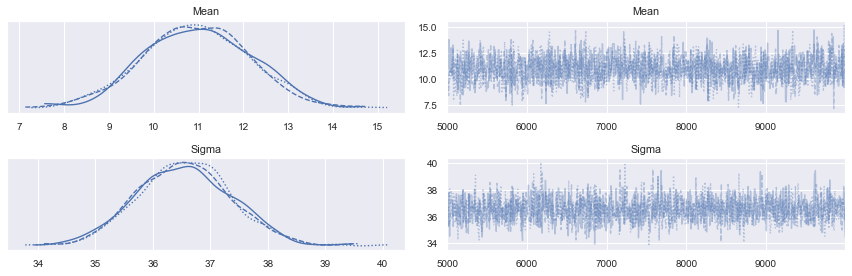

In [125]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations.flatten()

    def __call__(self, parameters):
        # Compute population contribution
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Sigma']

    def get_id(self):
        return [None, None]


log_likelihood = GaussianLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10000),
    pints.UniformLogPrior(0, 1000)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(3)
controller.set_parallel_evaluation(True)
controller.set_transform(pints.LogTransformation(log_posterior.n_parameters()))
n_iterations = 10000
gaussian_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=5000
thinning_ratio = 5
az.plot_trace(
    gaussian_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

### Visualise data and Gaussian fit

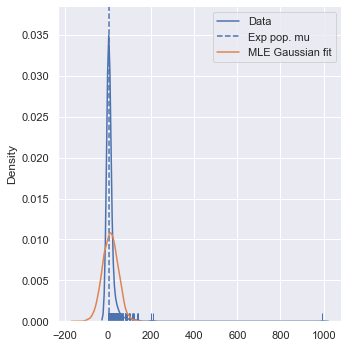

In [137]:
# Sample from Gaussian approximation
mean = 11
sigma = 36.5
gaussian_approx = np.random.normal(loc=mean, scale=sigma, size=10000)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.axvline(x=np.exp(true_parameters[0]), label='Exp pop. mu', linestyle='--')
sns.kdeplot(gaussian_approx, ax=ax, color=colors[1], label='MLE Gaussian fit')

plt.legend()
plt.show()